In [51]:
%matplotlib widget
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.utils import ElevationHandler, transform_coordinates
import matplotlib.pyplot as plt
import numpy as np

In [52]:
C2 = 20
f = 1000 # frequency [Hz]
c = 346 # speed of sound in air [m/s]
wavelength = c/f

e = 1 # distance between the screens in the direction of the source and receiver [m]
d_ss = 1 # perpendicular distance from source to plane of screen [m]
d_sr = 1 # perpendicular distance from plane of screen to receiver [m]

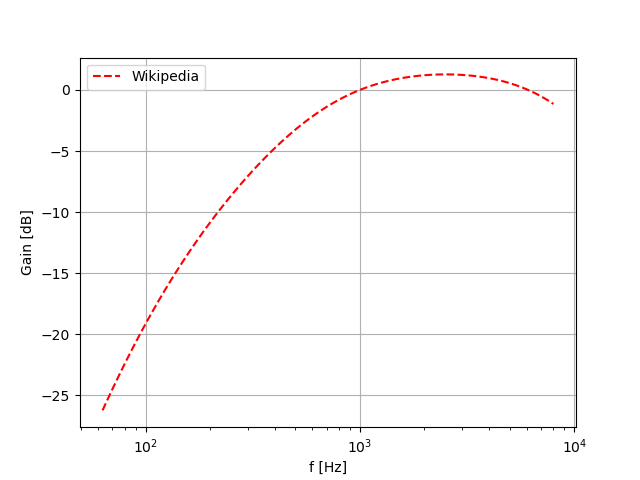

In [53]:
f = np.logspace(np.log10(63), np.log10(8000), 100, endpoint=True)
RAf = (12194**2 * f**4)/ ((f**2 + 20.6**2) * np.sqrt((f**2 + 107.7**2) * (f**2 + 737.9**2))* (f**2 + 12194**2))
Af = 20 * np.log10(RAf) + 2.00

fig, ax = plt.subplots()
ax.semilogx(f, Af, "r--", label = "Wikipedia")
ax.set(xlabel = "f [Hz]",
       ylabel = "Gain [dB]")
ax.grid()
ax.legend()



In [54]:
def calc_diffration(hs, hr, xt, yt):

    def diffration_recursion(xt, yt, xt_new, yt_new, start_i, ylp, diffraction_index):
        
        def calc_line(xt, ylp):
            m = (ylp[-1] - ylp[0]) / (xt[-1] - xt[0])
            b = ylp[0] - m * xt[0]
            yl = m * xt + b
            return yl

        yl = calc_line(xt_new, ylp)
        diff = (yl - yt_new)

        if np.any(diff < -1e-5): # if line collide with terrain
            yi_peak = np.argmin(diff) + start_i
            yimax = np.argmin(diff) # splitting index
            diffraction_index.append([xt[yi_peak], yt[yi_peak]])

            xt0 = xt_new[:yimax] # define new x
            if len(xt0) > 2:
                yt0 = yt_new[:yimax] # define new x
                ylp0 = calc_line(xt0, [yl[0], yt_new[yimax]])
                diffration_recursion(xt, yt, xt0, yt0, start_i, ylp0, diffraction_index)

            xt1 = xt_new[yimax + 1:]
            if len(xt1) > 2:
                yt1 = yt_new[yimax + 1:]
                start_i += yimax + 1
                ylp1 = calc_line(xt1, [yt_new[yimax], yl[-1]])
                diffration_recursion(xt, yt, xt1, yt1, start_i, ylp1, diffraction_index)
       
    diffraction_index = [[0, yt[0]+hs]] # init diffraction_index
    ylp = [yt[0]+hs, yt[-1]+hr] # point height at start and end of line
    xt_new, yt_new = xt, yt
    start_i = 0

    diffration_recursion(xt, yt, xt_new, yt_new, start_i, ylp, diffraction_index)

    diffraction_index = np.array([diffraction_index])[0,:,:]
    diffraction_index = diffraction_index[np.argsort(diffraction_index[:, 0])]
    diffraction_index = np.vstack((diffraction_index, np.array([xt[-1], yt[-1]+hr])))
    return diffraction_index

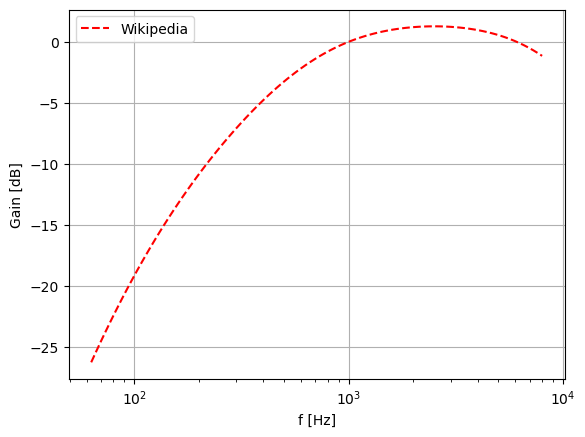

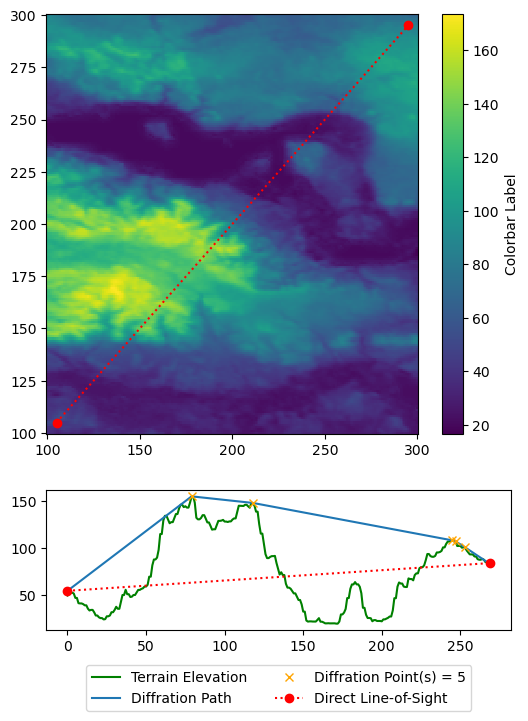

Length, ds:  319.0696000166085


No such comm: 07ff1af4e8ad4f759b750537d8115658


In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

z = np.loadtxt("../../assets/map.txt")
# z = np.loadtxt("map.txt")
x0, y0 = 105, 105
x1, y1 = 295, 295
length = np.ceil(np.hypot(x1-x0, y1-y0)).astype(int)
x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize = (6,8))

map_boundaries = [100, 300, 100, 300] # [x0, x1, y0, y1]
long_coord = np.linspace(map_boundaries[0], map_boundaries[1], z.shape[1])
lat_coord = np.linspace(map_boundaries[2], map_boundaries[3], z.shape[0])

pcm = axes[0].pcolormesh(long_coord, lat_coord, z)
axes[0].plot([x0, x1], [y0, y1], 'ro:')
cbar = fig.colorbar(pcm, ax=axes[0], orientation='vertical', label='Colorbar Label')
hs = 5 # source height
hr = 0 # receiver height
xt = np.arange(0, length, 1)

boxSize = np.array([map_boundaries[1]- map_boundaries[0], map_boundaries[3]- map_boundaries[2]])
gridsize = np.array(z.shape) - 1

xi = np.round(((x - map_boundaries[0]) / boxSize[0]) * gridsize[0]).astype(int)
yi = np.round(((y - map_boundaries[1]) / boxSize[1]) * gridsize[1]).astype(int)
yt = z.T[xi, yi]

diffraction_index =  calc_diffration(hs, hr, xt, yt)

axes[1].plot(xt, yt, label = "Terrain Elevation", color = "green")
axes[1].plot(*diffraction_index.T, label = "Diffration Path")
axes[1].plot(*diffraction_index[1:-1].T, color = "orange", marker = "x", label = f"Diffration Point(s) = {diffraction_index.shape[0]-2}", linestyle='None')
axes[1].plot([0, length], [yt[0]+hs, yt[-1]+hr], 'ro:', label = "Direct Line-of-Sight")
# plt.legend(loc = "best")
legend = axes[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()

ds = np.hypot(length, np.sum(np.abs(np.diff(diffraction_index[:,1])))) # length of diffraction path
print("Length, ds: ", ds)

In [56]:
import numpy as np
from scipy.interpolate import griddata
map_boundaries = [9.6, 9.8, 56.0, 56.2]
map_shape = [100, 100]
elevation_handler = ElevationHandler(map_boundaries, map_shape)
source_array = np.array([[9.77, 56.165, 5]])

def diffraction_data(elevation_handler, source_array):
    map_array = elevation_handler.map_array
    # map_array = np.loadtxt("map.txt")
    long_range = elevation_handler.long_range
    lat_range = elevation_handler.lat_range

    X, Y = np.meshgrid(long_range, lat_range)

    trans_cords = transform_coordinates(long_range, lat_range, input_crs_str = "EPSG:4326", output_crs_str = "EPSG:3035")

    map_array_flat = map_array.flatten()
    trans_long_flat = trans_cords[:, :, 0].flatten()
    trans_lat_flat = trans_cords[:, :, 1].flatten()

    d = np.empty(map_array_flat.shape + (source_array.shape[0],)) # direct path length
    ds = np.empty(map_array_flat.shape + (source_array.shape[0],)) # diffration path length
    trans_source = np.empty(3)

    for i, source in enumerate(source_array):

        elevation_source = griddata((X.flatten(), Y.flatten()), map_array_flat, (source[0], source[1]), method='linear')

        trans_source[:2] = transform_coordinates(source[0], source[1], input_crs_str = "EPSG:4326", output_crs_str = "EPSG:3035")
        trans_source[2] = source[2] + elevation_source
        for j in range(len(trans_long_flat)):

            SR_direct_vector = trans_source - np.array([trans_long_flat[j], trans_lat_flat[j], map_array_flat[j]])
            d[j, i] = np.sqrt((SR_direct_vector*SR_direct_vector).sum(axis=0))

            x0, y0 = trans_source[:2]
            x1, y1 = trans_long_flat[j], trans_lat_flat[j]
            
            length = np.ceil(np.hypot(x1-x0, y1-y0)).astype(int)
            x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

            hs = source[2] # source height
            hr = 0 # receiver height
            xt = np.arange(0, length, 1)

            # boxSize = np.array([max(trans_long_flat)- min(trans_long_flat), max(trans_long_flat)- min(trans_lat_flat)])
            boxSize = np.array([np.max(trans_long_flat)- np.min(trans_long_flat), np.max(trans_lat_flat)- np.min(trans_lat_flat)])
            gridsize = np.array(map_array.shape) - 1

            xi = np.round(((x - np.min(trans_long_flat)) / boxSize[0]) * gridsize[0]).astype(int)
            yi = np.round(((y - np.min(trans_lat_flat)) / boxSize[1]) * gridsize[1]).astype(int)
            yt = map_array.T[xi, yi]

            diffraction_index = calc_diffration(hs, hr, xt, yt)
            ds[j, i] = np.hypot(length, np.sum(np.abs(np.diff(diffraction_index[:,1]))))+np.sum(np.abs(np.diff(diffraction_index[:,1]))) # length of diffraction path   

    d = d.reshape(map_array.shape + (source_array.shape[0],))
    ds = ds.reshape(map_array.shape + (source_array.shape[0],))
    return d, ds

d, ds = diffraction_data(elevation_handler, source_array)

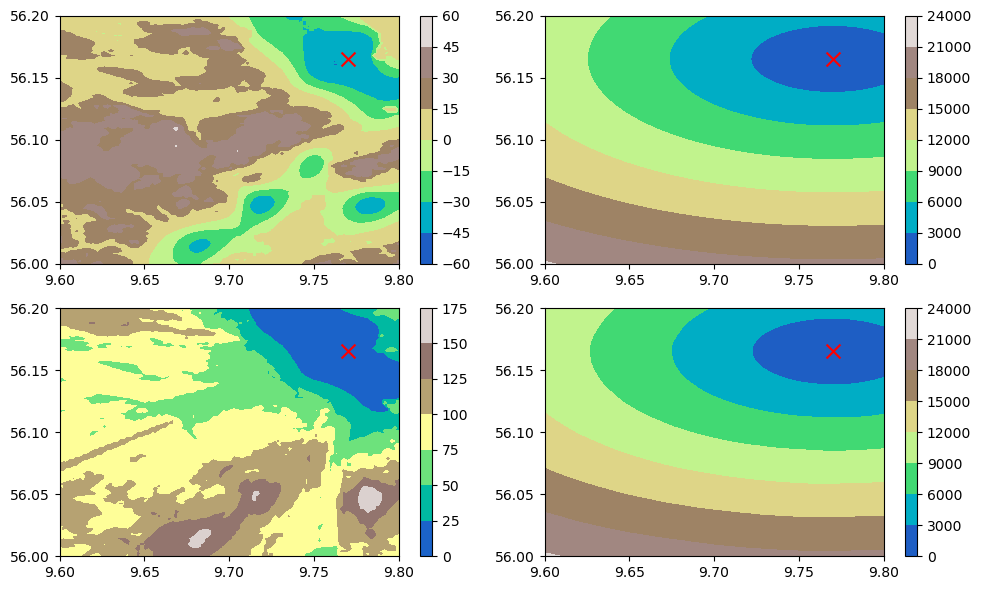

In [75]:
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
map_array = np.loadtxt("map.txt")

fig, axes = plt.subplots(2,2, figsize=(10, 6))
pcm = axes[0, 0].contourf(elevation_handler.long_range, elevation_handler.lat_range, elevation_handler.map_array, cmap = "terrain")
plt.colorbar(pcm, ax = axes[0,0])
axes[0, 0].scatter(*source_array[0,:2], marker = "x", color = "red", s = 100)

pcm = axes[0, 1].contourf(elevation_handler.long_range, elevation_handler.lat_range, d[:,:,0], cmap = "terrain")
plt.colorbar(pcm, ax = axes[0, 1])
axes[0, 1].scatter(*source_array[0,:2], marker = "x", color = "red", s = 100)

pcm = axes[1, 1].contourf(elevation_handler.long_range, elevation_handler.lat_range, ds[:,:,0], cmap = "terrain")
plt.colorbar(pcm, ax = axes[1, 1])
axes[1, 1].scatter(*source_array[0, :2], marker = "x", color = "red", s = 100)

pcm = axes[1, 0].contourf(elevation_handler.long_range, elevation_handler.lat_range, (ds[:,:,0]-d[:,:,0]), cmap = "terrain")
plt.colorbar(pcm, ax = axes[1, 0])
axes[1, 0].scatter(*source_array[0, :2], marker = "x", color = "red", s = 100)
plt.tight_layout()